In [20]:
from mesa.discrete_space import FixedAgent


class Cell(FixedAgent):
    """Represents a single ALIVE or DEAD cell in the simulation."""

    DEAD = 0
    ALIVE = 1

    @property
    def x(self):
        return self.cell.coordinate[0]

    @property
    def y(self):
        return self.cell.coordinate[1]

    def __init__(self, model, cell, init_state=DEAD):
        """Create a cell, in the given state, at the given x, y position."""
        super().__init__(model)
        self.cell = cell
        self.state = init_state
        self._next_state = None

    @property
    def is_alive(self):
        return self.state == self.ALIVE

    @property
    def neighbors(self):
        return self.cell.neighborhood.agents

    def determine_state(self):
        """Compute if the cell will be dead or alive at the next tick.  This is
        based on the number of alive or dead neighbors.  The state is not
        changed here, but is just computed and stored in self._nextState,
        because our current state may still be necessary for our neighbors
        to calculate their next state.
        """
        # Get the neighbors and apply the rules on whether to be alive or dead
        # at the next tick.
        live_neighbors = sum(neighbor.is_alive for neighbor in self.neighbors)

        # Assume nextState is unchanged, unless changed below.
        self._next_state = self.state
        if self.is_alive:
            if live_neighbors < 2 or live_neighbors > 3:
                self._next_state = self.DEAD
        else:
            if live_neighbors == 3:
                self._next_state = self.ALIVE

    def assume_state(self):
        """Set the state to the new computed state -- computed in step()."""
        self.state = self._next_state

from mesa import Model
from mesa.discrete_space import OrthogonalMooreGrid
from mesa.examples.basic.conways_game_of_life.agents import Cell


class ConwaysGameOfLife(Model):
    """Represents the 2-dimensional array of cells in Conway's Game of Life."""

    def __init__(self, width=50, height=50, initial_fraction_alive=0.2, seed=42):
        """Create a new playing area of (width, height) cells."""
        super().__init__(seed=seed)
        # Use a simple grid, where edges wrap around.
        self.grid = OrthogonalMooreGrid((width, height), capacity=1, torus=True)

        # Place a cell at each location, with some initialized to
        # ALIVE and some to DEAD.
        for cell in self.grid.all_cells:
            Cell(
                self,
                cell,
                init_state=Cell.ALIVE
                if self.random.random() < initial_fraction_alive
                else Cell.DEAD,
            )

        self.running = True

    def step(self):
        """Perform the model step in two stages:
        - First, all cells assume their next state (whether they will be dead or alive)
        - Then, all cells change state to their next state.
        """
        self.agents.do("determine_state")
        self.agents.do("assume_state")

AttributeError: 'SpaceRenderer' object has no attribute 'setup_agents'

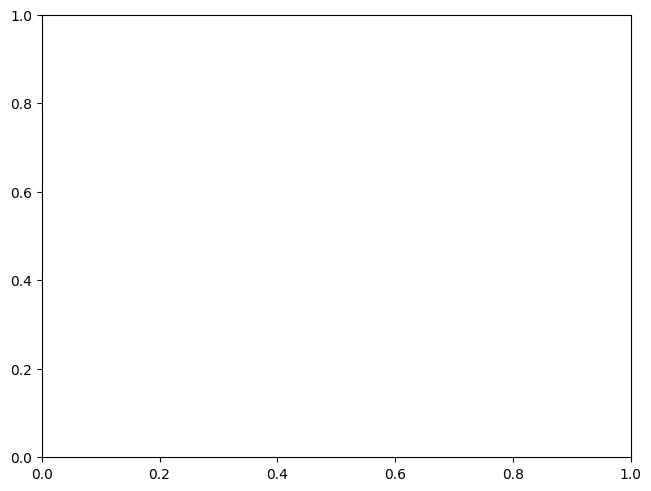

In [33]:
from mesa.examples.basic.conways_game_of_life.model import ConwaysGameOfLife
from mesa.visualization import (
    SolaraViz,
    SpaceRenderer,
)
from mesa.visualization.components import AgentPortrayalStyle


def agent_portrayal(agent):
    return AgentPortrayalStyle(
        color="white" if agent.state == 0 else "black",
        marker="s",
        size=30,
    )


def post_process(ax):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])


model_params = {
    "seed": {
        "type": "InputText",
        "value": 42,
        "label": "Random Seed",
    },
    "width": {
        "type": "SliderInt",
        "value": 50,
        "label": "Width",
        "min": 5,
        "max": 60,
        "step": 1,
    },
    "height": {
        "type": "SliderInt",
        "value": 50,
        "label": "Height",
        "min": 5,
        "max": 60,
        "step": 1,
    },
    "initial_fraction_alive": {
        "type": "SliderFloat",
        "value": 0.2,
        "label": "Cells initially alive",
        "min": 0,
        "max": 1,
        "step": 0.01,
    },
}

# Create initial model instance
model1 = ConwaysGameOfLife()

renderer = SpaceRenderer(model1, backend="matplotlib", ).setup_agents(agent_portrayal)
# In this case the renderer only draws the agents because we just want to observe
# the state of the agents, not the structure of the grid.
renderer.draw_agents()
renderer.post_process = post_process

# Create the SolaraViz page. This will automatically create a server and display the
# visualization elements in a web browser.
# Display it using the following command in the example directory:
# solara run app.py
# It will automatically update and display any changes made to this file
page = SolaraViz(
    model1,
    renderer,
    model_params=model_params,
    name="Game of Life",
)
page  # noqa